In [1]:
# Day 22: LSTM Implementation with Muhammad Ali Text - Detailed Explanation
# =======================================================================

# What are LSTMs?
# LSTMs (Long Short-Term Memory) are a special type of RNN that can remember
# information for long periods. They solve the vanishing gradient problem of
# traditional RNNs by using gates to control information flow.

# Key Components of LSTM:
# 1. Forget Gate: Decides what information to discard from cell state
# 2. Input Gate: Decides which values to update in cell state
# 3. Output Gate: Decides what parts of cell state to output
# 4. Cell State: The "memory" of the LSTM that flows through time

# Import necessary libraries
import torch               # Main PyTorch library
import torch.nn as nn     # Neural network modules
import numpy as np        # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import string            # For text processing
from collections import Counter  # For counting characters

print("✅ All libraries imported successfully!")
print("📚 Ready to learn LSTMs with Muhammad Ali text!")

✅ All libraries imported successfully!
📚 Ready to learn LSTMs with Muhammad Ali text!


In [2]:
# Muhammad Ali Text Data
# =====================
# We'll use this famous paragraph about Muhammad Ali to train our LSTM
# The model will learn patterns in this text and generate similar content

ali_text = """
Muhammad Ali was born Cassius Clay in Louisville Kentucky in 1942. He became the 
world heavyweight boxing champion three times and was known for his incredible speed 
and agility in the ring. Ali was famous for his confident personality and memorable 
quotes like float like a butterfly sting like a bee. He converted to Islam in 1964 
and changed his name from Cassius Clay to Muhammad Ali. During the Vietnam War he 
refused to be drafted and lost his boxing license for three years. Ali returned to 
boxing and reclaimed his title multiple times. He retired in 1981 and became a 
global icon for peace and humanitarian causes. Ali died in 2016 but remains the 
greatest boxer of all time.
"""

print("Original Muhammad Ali Text:")
print("=" * 50)
print(ali_text)
print(f"\n📊 Text Statistics:")
print(f"   • Total characters: {len(ali_text)}")
print(f"   • Total words: {len(ali_text.split())}")

# Text Preprocessing
# ==================
# We need to clean and prepare the text for our LSTM model

# Step 1: Convert to lowercase (standardization)
ali_text = ali_text.lower()

# Step 2: Remove extra whitespace and newlines
ali_text = ' '.join(ali_text.split())

# Step 3: Remove punctuation except periods (keep sentence structure)
# We keep periods to help the model learn sentence boundaries
ali_text = ali_text.translate(str.maketrans('', '', string.punctuation.replace('.', '')))

print("\n🧹 Cleaned Text (first 100 characters):")
print(ali_text[:100] + "...")
print(f"\n📊 After cleaning:")
print(f"   • Total characters: {len(ali_text)}")

Original Muhammad Ali Text:

Muhammad Ali was born Cassius Clay in Louisville Kentucky in 1942. He became the 
world heavyweight boxing champion three times and was known for his incredible speed 
and agility in the ring. Ali was famous for his confident personality and memorable 
quotes like float like a butterfly sting like a bee. He converted to Islam in 1964 
and changed his name from Cassius Clay to Muhammad Ali. During the Vietnam War he 
refused to be drafted and lost his boxing license for three years. Ali returned to 
boxing and reclaimed his title multiple times. He retired in 1981 and became a 
global icon for peace and humanitarian causes. Ali died in 2016 but remains the 
greatest boxer of all time.


📊 Text Statistics:
   • Total characters: 694
   • Total words: 120

🧹 Cleaned Text (first 100 characters):
muhammad ali was born cassius clay in louisville kentucky in 1942. he became the world heavyweight b...

📊 After cleaning:
   • Total characters: 684


In [3]:
# Creating Character Vocabulary
# =============================
# For character-level text generation, we need to:
# 1. Find all unique characters in our text
# 2. Create mappings between characters and numbers
# 3. Convert text to numerical sequences

# Step 1: Get unique characters and sort them
chars = sorted(list(set(ali_text)))
vocab_size = len(chars)

print("🔤 Character Vocabulary:")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Characters: {chars}")

# Step 2: Create character-to-index and index-to-character mappings
# These dictionaries help us convert between text and numbers
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

print("\n🔄 Mapping Examples:")
print(f"   • Character 'a' maps to index: {char_to_idx['a']}")
print(f"   • Index 0 maps to character: '{idx_to_char[0]}'")
print(f"   • Character ' ' (space) maps to index: {char_to_idx[' ']}")

# Step 3: Convert entire text to numerical sequence
# This creates a list of numbers representing our text
text_as_numbers = [char_to_idx[char] for char in ali_text]

print(f"\n🔢 Text as Numbers (first 20):")
print(f"   • Numbers: {text_as_numbers[:20]}")
print(f"   • Back to text: {''.join([idx_to_char[idx] for idx in text_as_numbers[:20]])}")

🔤 Character Vocabulary:
   • Vocabulary size: 33
   • Characters: [' ', '.', '0', '1', '2', '4', '6', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']

🔄 Mapping Examples:
   • Character 'a' maps to index: 9
   • Index 0 maps to character: ' '
   • Character ' ' (space) maps to index: 0

🔢 Text as Numbers (first 20):
   • Numbers: [20, 28, 16, 9, 20, 20, 9, 12, 0, 9, 19, 17, 0, 30, 9, 26, 0, 10, 22, 25]
   • Back to text: muhammad ali was bor


In [5]:
# Creating Training Sequences
# ===========================
# LSTMs learn by seeing sequences of data and predicting the next item
# We'll create overlapping sequences from our text using a sliding window

# Sequence length: how many characters the LSTM sees to predict the next one
sequence_length = 25  # Look at 25 characters to predict the 26th

# Function to create sequences
def create_sequences(text_numbers, seq_len):
    """
    Creates training sequences using sliding window approach
    
    Args:
        text_numbers: List of numbers representing text
        seq_len: Length of each input sequence
    
    Returns:
        input_sequences: List of input sequences
        target_chars: List of target characters (what to predict)
    """
    input_sequences = []
    target_chars = []
    
    # Slide through the text creating sequences
    for i in range(len(text_numbers) - seq_len):
        # Input: sequence of seq_len characters
        input_seq = text_numbers[i:i + seq_len]
        # Target: the next character after the sequence
        target = text_numbers[i + seq_len]
        
        input_sequences.append(input_seq)
        target_chars.append(target)
    
    return input_sequences, target_chars

# Create sequences
input_sequences, target_chars = create_sequences(text_as_numbers, sequence_length)

print(f"📝 Training Sequences Created:")
print(f"   • Number of sequences: {len(input_sequences)}")
print(f"   • Sequence length: {sequence_length}")
print(f"   • Total targets: {len(target_chars)}")

# Show an example sequence
print(f"\n🔍 Example Training Pair:")
print(f"   • Input sequence (as text): '{[''.join([idx_to_char[idx] for idx in input_sequences[0]])]}")
print(f"   • Target character: '{idx_to_char[target_chars[0]]}'")
print(f"   • Input sequence (as numbers): {input_sequences[0][:10]}...")
print(f"   • Target number: {target_chars[0]}")

📝 Training Sequences Created:
   • Number of sequences: 659
   • Sequence length: 25
   • Total targets: 659

🔍 Example Training Pair:
   • Input sequence (as text): '['muhammad ali was born cas']
   • Target character: 's'
   • Input sequence (as numbers): [20, 28, 16, 9, 20, 20, 9, 12, 0, 9]...
   • Target number: 26


In [6]:
# LSTM Model Architecture
# =======================
# Our LSTM model has three main components:
# 1. Embedding Layer: Converts character indices to dense vectors
# 2. LSTM Layer: Processes sequences and maintains memory
# 3. Linear Layer: Converts LSTM output to character predictions

class CharacterLSTM(nn.Module):
    """
    Character-level LSTM for text generation
    
    Architecture:
    Input → Embedding → LSTM → Linear → Output
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        """
        Initialize the LSTM model
        
        Args:
            vocab_size: Number of unique characters in vocabulary
            embedding_dim: Size of character embedding vectors
            hidden_dim: Size of LSTM hidden state
            num_layers: Number of LSTM layers
        """
        super(CharacterLSTM, self).__init__()
        
        # Store model parameters
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Layer 1: Embedding Layer
        # Converts character indices (0, 1, 2, ...) to dense vectors
        # Think of it as a lookup table where each character gets a unique vector
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Layer 2: LSTM Layer
        # This is the heart of our model - it processes sequences
        # batch_first=True means input shape is (batch_size, sequence_length, features)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=0.2)
        
        # Layer 3: Linear/Fully Connected Layer
        # Converts LSTM output to probability distribution over characters
        self.linear = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout for regularization (prevents overfitting)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length)
        
        Returns:
            output: Predictions of shape (batch_size, vocab_size)
        """
        # Step 1: Convert character indices to embeddings
        # Shape: (batch_size, sequence_length) → (batch_size, sequence_length, embedding_dim)
        embedded = self.embedding(x)
        
        # Step 2: Pass through LSTM
        # lstm_out: (batch_size, sequence_length, hidden_dim)
        # hidden: final hidden state (we don't use this for prediction)
        lstm_out, hidden = self.lstm(embedded)
        
        # Step 3: Apply dropout for regularization
        lstm_out = self.dropout(lstm_out)
        
        # Step 4: Use only the last timestep's output for prediction
        # Shape: (batch_size, sequence_length, hidden_dim) → (batch_size, hidden_dim)
        last_output = lstm_out[:, -1, :]
        
        # Step 5: Convert to character probabilities
        # Shape: (batch_size, hidden_dim) → (batch_size, vocab_size)
        output = self.linear(last_output)
        
        return output

# Model hyperparameters
embedding_dim = 50    # Size of character embeddings
hidden_dim = 128      # Size of LSTM hidden state
num_layers = 2        # Number of LSTM layers

# Create the model
model = CharacterLSTM(vocab_size, embedding_dim, hidden_dim, num_layers)

print("🏗️ LSTM Model Created!")
print(f"   • Vocabulary size: {vocab_size}")
print(f"   • Embedding dimension: {embedding_dim}")
print(f"   • Hidden dimension: {hidden_dim}")
print(f"   • Number of layers: {num_layers}")
print(f"\n📋 Model Architecture:")
print(model)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\n📊 Total parameters: {total_params:,}")

🏗️ LSTM Model Created!
   • Vocabulary size: 33
   • Embedding dimension: 50
   • Hidden dimension: 128
   • Number of layers: 2

📋 Model Architecture:
CharacterLSTM(
  (embedding): Embedding(33, 50)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

📊 Total parameters: 230,163


In [7]:
# Data Preparation for Training
# =============================
# Convert our Python lists to PyTorch tensors for efficient training

# Convert sequences to PyTorch tensors
# tensor with dtype=torch.long is used for integer indices
X = torch.tensor(input_sequences, dtype=torch.long)
y = torch.tensor(target_chars, dtype=torch.long)

print(f"📦 Data Tensors Created:")
print(f"   • Input shape: {X.shape}")
print(f"   • Target shape: {y.shape}")
print(f"   • Input data type: {X.dtype}")
print(f"   • Target data type: {y.dtype}")

# Train-Test Split
# ================
# Split data into training and validation sets
# 80% for training, 20% for validation

train_size = int(0.8 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]
y_val = y[train_size:]

print(f"\n📊 Data Split:")
print(f"   • Training samples: {len(X_train)}")
print(f"   • Validation samples: {len(X_val)}")
print(f"   • Training percentage: {train_size/len(X)*100:.1f}%")

# Training Setup
# ==============
# Define loss function and optimizer

# CrossEntropyLoss: Perfect for multi-class classification (predicting next character)
# It combines LogSoftmax and NLLLoss in one single class
criterion = nn.CrossEntropyLoss()

# Adam optimizer: Adaptive learning rate optimizer
# It's generally better than SGD for most deep learning tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Learning rate scheduler: Reduces learning rate when loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

print(f"\n⚙️ Training Setup:")
print(f"   • Loss function: CrossEntropyLoss")
print(f"   • Optimizer: Adam")
print(f"   • Learning rate: 0.002")
print(f"   • Scheduler: ReduceLROnPlateau")
print(f"\n🚀 Ready to start training!")

📦 Data Tensors Created:
   • Input shape: torch.Size([659, 25])
   • Target shape: torch.Size([659])
   • Input data type: torch.int64
   • Target data type: torch.int64

📊 Data Split:
   • Training samples: 527
   • Validation samples: 132
   • Training percentage: 80.0%

⚙️ Training Setup:
   • Loss function: CrossEntropyLoss
   • Optimizer: Adam
   • Learning rate: 0.002
   • Scheduler: ReduceLROnPlateau

🚀 Ready to start training!

⚙️ Training Setup:
   • Loss function: CrossEntropyLoss
   • Optimizer: Adam
   • Learning rate: 0.002
   • Scheduler: ReduceLROnPlateau

🚀 Ready to start training!


In [8]:
# Training the LSTM Model
# =======================
# We'll train the model to predict the next character in sequences

# Training parameters
num_epochs = 100      # Number of complete passes through the data
batch_size = 32       # Number of sequences processed together

# Lists to store training progress
train_losses = []     # Training loss for each epoch
val_losses = []       # Validation loss for each epoch

print("🎯 Starting LSTM Training...")
print("=" * 50)

# Training loop
for epoch in range(num_epochs):
    # ============
    # TRAINING PHASE
    # ============
    model.train()  # Set model to training mode (enables dropout, etc.)
    epoch_train_loss = 0
    num_batches = 0
    
    # Process data in batches for efficiency
    for i in range(0, len(X_train), batch_size):
        # Get current batch
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]
        
        # Forward pass
        optimizer.zero_grad()        # Clear gradients from previous step
        outputs = model(batch_X)     # Get model predictions
        loss = criterion(outputs, batch_y)  # Calculate loss
        
        # Backward pass
        loss.backward()              # Compute gradients
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()             # Update model parameters
        
        # Track loss
        epoch_train_loss += loss.item()
        num_batches += 1
    
    # Calculate average training loss
    avg_train_loss = epoch_train_loss / num_batches
    train_losses.append(avg_train_loss)
    
    # ================
    # VALIDATION PHASE
    # ================
    model.eval()  # Set model to evaluation mode (disables dropout)
    val_loss = 0
    val_batches = 0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for i in range(0, len(X_val), batch_size):
            batch_X = X_val[i:i + batch_size]
            batch_y = y_val[i:i + batch_size]
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"LR: {current_lr:.6f}")

print("\n✅ Training completed!")
print(f"   • Final training loss: {train_losses[-1]:.4f}")
print(f"   • Final validation loss: {val_losses[-1]:.4f}")
print(f"   • Best validation loss: {min(val_losses):.4f}")

🎯 Starting LSTM Training...
Epoch [ 10/100] | Train Loss: 1.8443 | Val Loss: 2.3433 | LR: 0.002000
Epoch [ 10/100] | Train Loss: 1.8443 | Val Loss: 2.3433 | LR: 0.002000
Epoch [ 20/100] | Train Loss: 0.8668 | Val Loss: 2.6213 | LR: 0.001000
Epoch [ 20/100] | Train Loss: 0.8668 | Val Loss: 2.6213 | LR: 0.001000
Epoch [ 30/100] | Train Loss: 0.5590 | Val Loss: 2.8138 | LR: 0.000250
Epoch [ 30/100] | Train Loss: 0.5590 | Val Loss: 2.8138 | LR: 0.000250
Epoch [ 40/100] | Train Loss: 0.4679 | Val Loss: 2.8771 | LR: 0.000063
Epoch [ 40/100] | Train Loss: 0.4679 | Val Loss: 2.8771 | LR: 0.000063
Epoch [ 50/100] | Train Loss: 0.4619 | Val Loss: 2.9033 | LR: 0.000031
Epoch [ 50/100] | Train Loss: 0.4619 | Val Loss: 2.9033 | LR: 0.000031
Epoch [ 60/100] | Train Loss: 0.4493 | Val Loss: 2.9097 | LR: 0.000008
Epoch [ 60/100] | Train Loss: 0.4493 | Val Loss: 2.9097 | LR: 0.000008
Epoch [ 70/100] | Train Loss: 0.4463 | Val Loss: 2.9123 | LR: 0.000002
Epoch [ 70/100] | Train Loss: 0.4463 | Val Loss: 

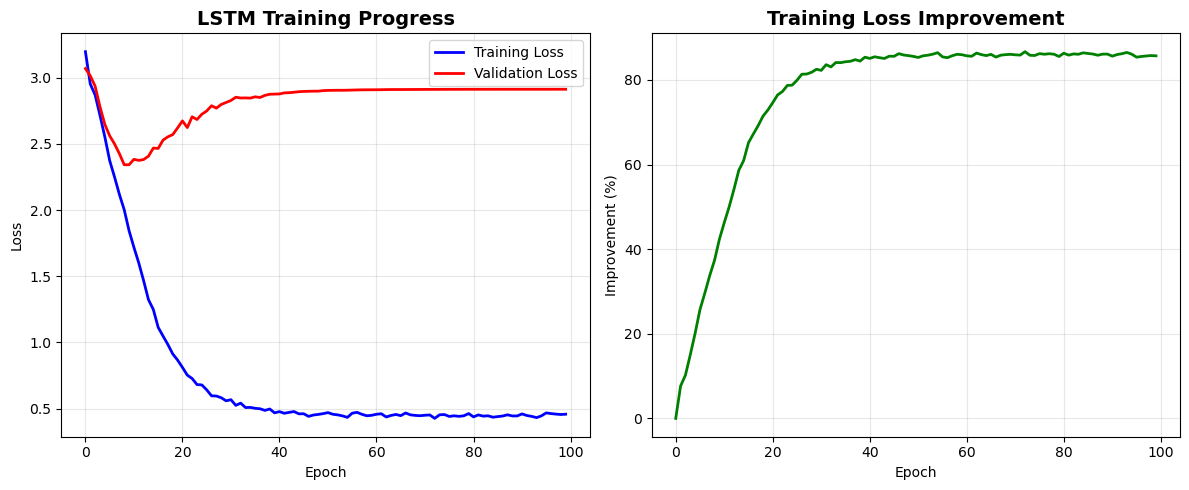

📈 Training Statistics:
   • Starting loss: 3.1977
   • Final loss: 0.4577
   • Total improvement: 85.7%
   • Best epoch (lowest val loss): 9


In [9]:
# Visualizing Training Progress
# =============================
# Let's plot the training and validation losses to see how our model learned

plt.figure(figsize=(12, 5))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
plt.title('LSTM Training Progress', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss Improvement
plt.subplot(1, 2, 2)
improvement = [(train_losses[0] - loss) / train_losses[0] * 100 for loss in train_losses]
plt.plot(improvement, color='green', linewidth=2)
plt.title('Training Loss Improvement', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Improvement (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training statistics
print(f"📈 Training Statistics:")
print(f"   • Starting loss: {train_losses[0]:.4f}")
print(f"   • Final loss: {train_losses[-1]:.4f}")
print(f"   • Total improvement: {improvement[-1]:.1f}%")
print(f"   • Best epoch (lowest val loss): {val_losses.index(min(val_losses)) + 1}")

In [10]:
# Text Generation with Trained LSTM
# =================================
# The most exciting part! Let's use our trained model to generate new text

def generate_text(model, seed_text, length=200, temperature=0.8):
    """
    Generate text using the trained LSTM model
    
    Args:
        model: Trained LSTM model
        seed_text: Starting text to begin generation
        length: Number of characters to generate
        temperature: Controls randomness (lower = more predictable)
    
    Returns:
        generated_text: New text generated by the model
    """
    # Set model to evaluation mode
    model.eval()
    
    # Convert seed text to lowercase and prepare
    seed_text = seed_text.lower()
    generated = seed_text
    
    # Convert seed text to numbers
    current_seq = [char_to_idx.get(c, char_to_idx[' ']) for c in seed_text]
    
    # Generate new characters one by one
    with torch.no_grad():  # No gradients needed for generation
        for _ in range(length):
            # Prepare input sequence
            if len(current_seq) >= sequence_length:
                # Use last sequence_length characters
                input_seq = current_seq[-sequence_length:]
            else:
                # Pad with spaces if sequence is too short
                padding_needed = sequence_length - len(current_seq)
                input_seq = [char_to_idx[' ']] * padding_needed + current_seq
            
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([input_seq], dtype=torch.long)
            
            # Get model prediction
            output = model(input_tensor)
            
            # Apply temperature for controlled randomness
            # Higher temperature = more random, lower = more predictable
            output = output / temperature
            
            # Convert to probabilities
            probabilities = torch.softmax(output, dim=1)
            
            # Sample next character based on probabilities
            next_char_idx = torch.multinomial(probabilities, 1).item()
            next_char = idx_to_char[next_char_idx]
            
            # Add to generated text and update sequence
            generated += next_char
            current_seq.append(next_char_idx)
    
    return generated

print("🎨 Text Generation Function Ready!")
print("   • Temperature controls creativity:")
print("     - Low (0.3-0.7): More predictable, coherent")
print("     - High (0.8-1.2): More creative, random")
print("\n🚀 Let's generate some Muhammad Ali text!")

🎨 Text Generation Function Ready!
   • Temperature controls creativity:
     - Low (0.3-0.7): More predictable, coherent
     - High (0.8-1.2): More creative, random

🚀 Let's generate some Muhammad Ali text!


In [11]:
# Testing Text Generation
# =======================
# Let's test our model with different seed phrases and temperatures

# Different seed phrases to test
seed_phrases = [
    "muhammad ali was",
    "ali became",
    "boxing champion",
    "he was famous for"
]

# Test different temperatures
temperatures = [0.5, 0.8, 1.1]

print("🎭 Generated Text Examples")
print("=" * 60)

for i, seed in enumerate(seed_phrases):
    print(f"\n{i+1}. Seed: '{seed}'")
    print("-" * 40)
    
    # Generate with different temperatures
    for temp in temperatures:
        generated = generate_text(model, seed, length=150, temperature=temp)
        print(f"\n🌡️ Temperature {temp}:")
        print(generated)
        print()

# Custom generation
print("\n🎯 Custom Generation:")
print("=" * 30)
custom_seed = "the greatest boxer"
print(f"Starting with: '{custom_seed}'")
print("-" * 40)

# Generate longer text with optimal temperature
long_text = generate_text(model, custom_seed, length=300, temperature=0.7)
print(long_text)

print("\n" + "=" * 60)
print("🎉 Text generation complete! The model has learned to write about Muhammad Ali!")

🎭 Generated Text Examples

1. Seed: 'muhammad ali was'
----------------------------------------

🌡️ Temperature 0.5:
muhammad ali was ting was cond his inred his boxing like a bee. he wars and chamed his incredible yetam and was clay in louisville times. he reting the vietnam wor hi


🌡️ Temperature 0.8:
muhammad ali was famouss for his inag like a for and forslitle yetutrs like to his boxing lite spee wea gufos clay ike louitle times. he retislily in the ring. ali wa


🌡️ Temperature 1.1:
muhammad ali was tilis ricnla tishe nor has boxing thi surees. mor he wars hree seconf be recons aund to fo tor 1and chmaniole knham ake th resind lor licin lae an am


2. Seed: 'ali became'
----------------------------------------

🌡️ Temperature 0.8:
muhammad ali was famouss for his inag like a for and forslitle yetutrs like to his boxing lite spee wea gufos clay ike louitle times. he retislily in the ring. ali wa


🌡️ Temperature 1.1:
muhammad ali was tilis ricnla tishe nor has boxing thi surees. 

## 🎯 What We Just Accomplished!

### 📚 **Key Learning Points:**

1. **LSTM Architecture Understanding:**
   - **Embedding Layer**: Converts characters to dense vectors
   - **LSTM Layer**: Processes sequences with memory capabilities
   - **Linear Layer**: Converts LSTM output to character predictions

2. **Text Processing Pipeline:**
   - Text cleaning and preprocessing
   - Character-level vocabulary creation
   - Sequence generation with sliding window
   - Tensor conversion for PyTorch

3. **Training Process:**
   - Forward pass through LSTM
   - Loss calculation with CrossEntropyLoss
   - Backpropagation and parameter updates
   - Validation monitoring and learning rate scheduling

4. **Text Generation:**
   - Sequential character prediction
   - Temperature-controlled sampling
   - Seed text continuation

### 🧠 **How LSTMs Work (Simple Explanation):**

- **Memory Cells**: Store important information
- **Forget Gate**: Decides what to forget from previous steps
- **Input Gate**: Decides what new information to store
- **Output Gate**: Decides what to output based on memory

### 🚀 **Next Steps to Improve:**

1. **More Data**: Use larger text datasets
2. **Word-Level**: Try word-level instead of character-level
3. **Bidirectional LSTM**: Process text in both directions
4. **Attention Mechanism**: Add attention for better context
5. **Pre-trained Models**: Use models like GPT for better results

### 💡 **Key Takeaways:**

- LSTMs are powerful for sequential data
- Character-level models can generate coherent text
- Temperature controls creativity vs. coherence
- Proper preprocessing is crucial
- Training monitoring prevents overfitting

**Congratulations! You've successfully implemented and trained an LSTM for text generation! 🎉**